In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plot
import seaborn
import re

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import scipy.stats as stats

In [9]:
# Configure how graphs will show up in this notebook
%matplotlib inline
seaborn.set_context('notebook', rc={'figure.figsize': (50, 50)}, font_scale=1.5)

In [2]:
%%time
def load_embeddings(filename):
    """
    Load a DataFrame from the generalized text format used by word2vec, GloVe,
    fastText, and ConceptNet Numberbatch. The main point where they differ is
    whether there is an initial line with the dimensions of the matrix.
    """
    labels = []
    rows = []
    with open(filename, encoding='utf-8') as infile:
        for i, line in enumerate(infile):
            items = line.rstrip().split(' ')
            if len(items) == 2:
                # This is a header row giving the shape of the matrix
                continue
            labels.append(items[0])
            values = np.array([float(x) for x in items[1:]], 'f')
            rows.append(values)
    
    arr = np.vstack(rows)
    return pd.DataFrame(arr, index=labels, dtype='f')

CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 6.2 µs


In [5]:
%%time 
glove_840B_embeddings = load_embeddings('data/embeddings/glove/glove.840B.300d.txt')
glove_840B_embeddings.shape

KeyboardInterrupt: 

In [3]:
%%time 
glove_6B_300d_embeddings = load_embeddings('data/embeddings/glove/glove.6B.300d.txt')
glove_6B_300d_embeddings.shape

CPU times: user 21.6 s, sys: 848 ms, total: 22.4 s
Wall time: 22.2 s


(400000, 300)

In [7]:
## Loading word2vec
from conceptnet5.vectors.formats import load_word2vec_bin
w2v = load_word2vec_bin('data/embeddings/word2vec/word2vec-googlenews-300.bin.gz', nrows=2000000)

# word2vec is case-sensitive, so case-fold its labels
w2v.index = [label.casefold() for label in w2v.index]

# Now we have duplicate labels, so drop the later (lower-frequency) occurrences of the same label
w2v = w2v.reset_index().drop_duplicates(subset='index', keep='first').set_index('index')

KeyboardInterrupt: 

In [4]:
def load_lexicon(filename):
    """
    Load a file from Bing Liu's sentiment lexicon
    (https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html), containing
    English words in Latin-1 encoding.
    
    One file contains a list of positive words, and the other contains
    a list of negative words. The files contain comment lines starting
    with ';' and blank lines, which should be skipped.
    """
    lexicon = []
    with open(filename, encoding='latin-1') as infile:
        for line in infile:
            line = line.rstrip()
            if line and not line.startswith(';'):
                lexicon.append(line)
    return lexicon

In [5]:
pos_words = load_lexicon('data/lexicons/hu_liu_2004/opinion-lexicon-English/positive-words.txt')
neg_words = load_lexicon('data/lexicons/hu_liu_2004/opinion-lexicon-English/negative-words.txt')

print(len(pos_words), len(neg_words))

2006 4783


In [6]:
pos_words_common = list(set(pos_words) & set(glove_6B_300d_embeddings.index)) 
neg_words_common = list(set(neg_words) & set(glove_6B_300d_embeddings.index)) 
pos_vectors = glove_6B_300d_embeddings.loc[pos_words_common]
neg_vectors = glove_6B_300d_embeddings.loc[neg_words_common]
vectors = pd.concat([pos_vectors, neg_vectors])
targets = np.array([1 for entry in pos_vectors.index] + [-1 for entry in neg_vectors.index])
labels = list(pos_vectors.index) + list(neg_vectors.index)

In [10]:
pos_vectors.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
upscale,0.326700,0.440310,0.27021,-0.083099,0.385910,0.48372,0.242900,0.33570,-0.060518,-0.44930,...,0.046882,-0.013723,-0.12263,0.310650,0.065257,0.060959,0.260770,0.087547,-0.098923,-0.230280
cheapest,-0.087459,0.532400,0.41479,-0.099595,0.830590,0.40803,0.257870,-0.20273,-0.742570,-0.49510,...,-0.119580,-0.467170,0.41236,0.169180,-0.100830,-0.095395,-0.130840,-0.221540,0.351550,0.008503
topnotch,-0.483830,-0.135670,0.43951,0.258990,0.231090,0.65708,0.782740,1.02930,0.252140,0.91091,...,0.312980,-0.384740,0.35288,0.830960,-0.580360,-0.212710,0.479450,0.496530,0.874290,-0.108690
titillate,-0.111110,0.031328,0.55381,-0.050605,-0.158770,1.18890,-0.221000,-0.26587,-0.417020,0.78967,...,-0.084749,0.102160,0.53991,-0.098531,0.525110,-0.974250,-0.554620,0.083019,0.335940,0.038485
happy,-0.176120,0.109370,0.29458,-0.469490,-0.085332,-0.23072,0.001865,0.17469,0.069360,-0.68698,...,0.002189,-0.114440,-0.25003,-0.177860,-0.092675,-0.527340,-0.000776,0.057345,0.035544,0.057239


In [ ]:
import re
TOKEN_RE = re.compile(r"\w.*?\b")

def vecs_to_sentiment(model, vecs):
    # predict_log_proba gives the log probability for each class
    predictions = model.predict_log_proba(vecs)

    # To see an overall positive vs. negative classification in one number,
    # we take the log probability of positive sentiment minus the log
    # probability of negative sentiment.
    # this is a logarithm of the max margin for the classifier, 
    # similar to odds ratio (but not exact) log(p_1/p_0) = log(p_1)-log(p_0)
    return predictions[:, 1] - predictions[:, 0]


def words_to_sentiment(model, embeddings, words):
    vecs = embeddings.loc[embeddings.index.intersection(set(words))].dropna()
    # vecs = embeddings.loc[words].dropna()
    log_odds = vecs_to_sentiment(model, vecs)
    return pd.DataFrame({'sentiment': log_odds}, index=vecs.index)
    

def text_to_sentiment(model, embeddings, text):
    # tokenize the input phrase
    tokens = [token.casefold() for token in TOKEN_RE.findall(text)]
    # send each token separately into the embedding, then the classifier
    sentiments = words_to_sentiment(model, embeddings, tokens)
    return sentiments['sentiment'].mean() # return the mean for the classifier        

In [ ]:
def texts_to_sentiment(model, embeddings, texts):
    sentiments = pd.DataFrame(columns=['sentiment'])
    for text in texts:
        sentiments= pd.concat([sentiments, pd.DataFrame.from_records([{'sentiment': text_to_sentiment(model, embeddings, text)}])])
    return sentiments


In [ ]:
def category_sentiment_table(model, embeddings, group_data, isText=False):
    frames = []
    for group, name_list in sorted(group_data.items()):
        lower_names = [name.lower() for name in name_list]
        if isText:
            sentiments = texts_to_sentiment(model, embeddings, lower_names)
        else:
            sentiments = words_to_sentiment(model, embeddings, lower_names)
        sentiments['group'] = group
        frames.append(sentiments)

    # Put together the data we got from each ethnic group into one big table
    return pd.concat(frames)

In [7]:
len(set(glove_6B_300d_embeddings.index))

400000

In [13]:
len(set(pos_words))

2006

In [15]:
len(list(set(pos_words) & set(glove_6B_300d_embeddings.index)) )

1893

In [ ]:
pos_words_common = list(set(pos_words) & set(glove_6B_300d_embeddings.index)) 
neg_words_common = list(set(neg_words) & set(glove_6B_300d_embeddings.index)) 

In [ ]:
def train_model(embeddings, title = ''):
    # get the positive and negative embeddings
    pos_words_common = list(set(pos_words) & set(embeddings.index)) 
    neg_words_common = list(set(neg_words) & set(embeddings.index)) 
    pos_vectors = embeddings.loc[pos_words_common]
    neg_vectors = embeddings.loc[neg_words_common]
    vectors = pd.concat([pos_vectors, neg_vectors])
    targets = np.array([1 for entry in pos_vectors.index] + [-1 for entry in neg_vectors.index])
    labels = list(pos_vectors.index) + list(neg_vectors.index)

    # split the data
    train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels = \
        train_test_split(vectors, targets, labels, test_size=0.1, random_state=0)
    
    # train our model
    model = SGDClassifier(loss='log_loss', random_state=0, max_iter=100)
#     model.fit(train_vectors, train_targets)
    
#     # print out a goodness of fit
#     accuracy = accuracy_score(model.predict(test_vectors), test_targets)
#     print("Accuracy of sentiment: {:.2%}".format(accuracy))
    return model

In [ ]:
model_6B = train_model(glove_6B_300d_embeddings)

In [ ]:
model_840B = train_model(glove_840B_embeddings)

In [ ]:
model_w2v = train_model(w2v)

In [ ]:
# Gender by Name. (2020). UCI Machine Learning Repository. https://doi.org/10.24432/C55G7X.

gender_names = pd.read_csv("gender_bias_test_data/uci_gendered_names/name_gender_dataset.csv")

gender_names.info()

In [ ]:
num_f = gender_names[gender_names.Gender == 'F'].shape[0]
num_m = gender_names[gender_names.Gender == 'M'].shape[0]

print('There are {} female instants vs {} male instants'.format(num_f, num_m))

In [ ]:
GENDER_CAT_NAMES = {
    'female': gender_names[gender_names.Gender == 'F'].iloc[:num_m].Name.values,
    'male': gender_names[gender_names.Gender == 'M'].Name.values
}

In [ ]:
def cat_sentiment(model, embeddings, group_data, isText=False, swarmPlot=True):
    print("---- Get the sentiment table")
    # get the name table of different people's names and save embeddings
    category_sentiments = category_sentiment_table(model, embeddings, group_data, isText)
    
    stats_params = []
    for group in category_sentiments.group.unique():
        stats_params.append(category_sentiments['sentiment'][category_sentiments['group'] == group])
    
    print("---- Calculate F_oneway")
    stats.f_oneway(*stats_params)
    fstat,pval = stats.f_oneway(*stats_params)
    print('F-statistic:',fstat,' With P-value:', pval)

    # Show the results on a swarm plot, with a consistent Y-axis
    matplotlib.pyplot.figure(figsize=(15,5))
    matplotlib.pyplot.subplot(121)
    plot = None
    if swarmPlot:
        plot = seaborn.swarmplot(x='group', y='sentiment', data=category_sentiments)
    else:
        plot = seaborn.violinplot(x='group', y='sentiment', data=category_sentiments)
    plot.set_ylim([-10, 10])
    matplotlib.pyplot.subplot(122)
    plot = seaborn.barplot(x='group', y='sentiment', data=category_sentiments, capsize=.1)
    matplotlib.pyplot.suptitle("hehe", fontsize=16)

In [ ]:
cat_sentiment(model_840B ,glove_840B_embeddings, GENDER_CAT_NAMES, False, False)

In [ ]:
cat_sentiment(model_w2v ,w2v, GENDER_CAT_NAMES, False, False)

In [ ]:
# Gendered Words: https://github.com/ecmonsen/gendered_words

gendered_words = pd.read_json('gender_bias_test_data/gendered_words/gendred_words.json')

gendered_words.info()

In [ ]:
gendered_words = gendered_words.drop('gender_map', axis=1)
gendered_words = gendered_words.drop('wordnet_senseno', axis=1)

In [ ]:
gendered_words.info()

In [ ]:
num_f_2 = gendered_words[gendered_words.gender == 'f'].shape[0]
num_m_2 = gendered_words[gendered_words.gender == 'm'].shape[0]

print('There are {} female instants vs {} male instants'.format(num_f_2, num_m_2))

In [ ]:
GENDER_CAT_NAMES_2 = {
    'female': gendered_words[gendered_words.gender == 'f'].iloc[:num_f_2].word.values,
    'male': gendered_words[gendered_words.gender == 'm'].iloc[:num_f_2].word.values
}

In [ ]:
cat_sentiment(model_840B ,glove_840B_embeddings, GENDER_CAT_NAMES_2)

In [ ]:
cat_sentiment(model_w2v ,w2v, GENDER_CAT_NAMES_2)

In [12]:
# Google Case study for gender bias translations
# https://ai.google/static/documents/case-study-translate-gender-bias.pdf

google_translation = pd.read_csv("gender_bias_test_data/google_translation_gender_bias/google_en_es_gender_bias.csv")

In [ ]:
google_translation.info()

In [13]:

google_translation = google_translation.drop(
    [
        'sourceLanguage', 'targetLanguage', 'documentID', 'stringID',
        'translatedText', 'entityName', 'sourceURL'
    ],
    axis=1)

In [ ]:
google_translation.info()

In [ ]:
lengths = google_translation.sourceText.str.len()
plot.hist(lengths) 
plot.axis([0,550,0,800])
plot.xlabel('Text Length')
plot.ylabel('Count')
plot.show()

In [ ]:
print("Max length is {}".format(max(lengths)))
print("Min length is {}".format(min(lengths)))
print("Top 10 lengths: ", lengths.value_counts().nlargest(10).to_dict())

In [ ]:
MAX_LENGTH_STR = 513
# Truncate and padd sentences with zeros
google_translation['short_str'] = google_translation['sourceText'].str.slice(0,MAX_LENGTH_STR).str.zfill(MAX_LENGTH_STR)

In [ ]:
google_translation.perceivedGender.unique()

In [ ]:
num_f_3 = google_translation[google_translation.perceivedGender == 'Female'].shape[0]
num_m_3 = google_translation[google_translation.perceivedGender == 'Male'].shape[0]

print('There are {} female instants vs {} male instants'.format(num_f_3, num_m_3))

In [ ]:
NUMBER_SAMPLES = 100
GENDER_CAT_NAMES_3 = {
    'female': google_translation[google_translation.perceivedGender == 'Female'].sample(n=NUMBER_SAMPLES).short_str.values,
    'male': google_translation[google_translation.perceivedGender == 'Male'].sample(n=NUMBER_SAMPLES).short_str.values
}

In [ ]:
%%time
cat_sentiment(model_w2v ,w2v, GENDER_CAT_NAMES_3, True, False)

In [ ]:
%%time
cat_sentiment(model_6B ,glove_6B_300d_embeddings, GENDER_CAT_NAMES_3, True, False)

In [ ]:
%%time
cat_sentiment(model_840B ,glove_840B_embeddings, GENDER_CAT_NAMES_3, True, False)

In [ ]:
GENDER_CAT_NAMES_4 = {
    'female': ['trimester', 'homemaker', 'feminist', 'dancer', 'actresses', 'sisters', 'ladies', 'she', 'witch', 'wives', 'salon'],
    'male'  : ['he',        'sons',      'brothers', 'boyhood', 'priest',   'dads',     'man' ,  'boyfriend', 'actor', 'husbands', 'barber' ]
}

In [ ]:
cat_sentiment(model_840B ,glove_840B_embeddings, GENDER_CAT_NAMES_4)

# RNN

In [14]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from tensorflow.keras.layers import Embedding
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

In [15]:
vocabulary_size = 5000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words = vocabulary_size)
print('Loaded dataset with {} training samples, {} test samples'.format(len(X_train), len(X_test)))

17464789/17464789 [==============================] - 0s 0us/step
Loaded dataset with 25000 training samples, 25000 test samples


In [16]:
print('Maximum review length: {}'.format(len(max((X_train + X_test), key=len))))
print('Minimum review length: {}'.format(len(min((X_test + X_test), key=len))))

Maximum review length: 2697
Minimum review length: 14


In [17]:
max_words = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)

In [18]:
embedding_size=32
rnn_base=Sequential()
rnn_base.add(Embedding(vocabulary_size, embedding_size, input_length=max_words))
rnn_base.add(LSTM(100))
rnn_base.add(Dense(1, activation='sigmoid'))
print(rnn_base.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           160000    
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
rnn_base.compile(loss='binary_crossentropy', 
             optimizer='adam', 
             metrics=['accuracy'])

In [20]:
batch_size = 64
num_epochs = 3
X_valid, y_valid = X_train[:batch_size], y_train[:batch_size]
X_train2, y_train2 = X_train[batch_size:], y_train[batch_size:]
rnn_base.fit(X_train2, y_train2, validation_data=(X_valid, y_valid), batch_size=batch_size, epochs=num_epochs)

Epoch 1/3
390/390 [==============================] - 122s 310ms/step - loss: 0.4565 - accuracy: 0.7756 - val_loss: 0.2953 - val_accuracy: 0.8438
Epoch 2/3
390/390 [==============================] - 120s 309ms/step - loss: 0.2921 - accuracy: 0.8849 - val_loss: 0.3231 - val_accuracy: 0.9062
Epoch 3/3
390/390 [==============================] - 121s 310ms/step - loss: 0.2669 - accuracy: 0.8952 - val_loss: 0.2536 - val_accuracy: 0.9062


In [21]:
scores = rnn_base.evaluate(X_test, y_test, verbose=0)
print('Test accuracy:', scores[1])

Test accuracy: 0.8618800044059753


In [ ]:
google_translation.info()

In [ ]:
X_test.shape

In [ ]:
type(X_test)

In [ ]:
google_translation[google_translation.perceivedGender == 'Female'].sample(n=2).sourceText.shape

In [22]:
NUM_TOP_WORDS = 5000
MAX_ART_LEN = 500
female_pre = google_translation[google_translation.perceivedGender == 'Female'].sourceText
tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(female_pre)
sequences = tokenizer.texts_to_sequences(female_pre)
word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

female_X = pad_sequences(sequences, maxlen=MAX_ART_LEN)


Found 3365 unique tokens. Distilled to 3365 top words.


In [23]:
NUM_TOP_WORDS = 5000
MAX_ART_LEN = 500
male_pre = google_translation[google_translation.perceivedGender == 'Male'].sourceText
tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(female_pre)
sequences = tokenizer.texts_to_sequences(male_pre)
word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

male_X = pad_sequences(sequences, maxlen=MAX_ART_LEN)

Found 3365 unique tokens. Distilled to 3365 top words.


In [ ]:
# 'female': google_translation[google_translation.perceivedGender == 'Female'].sample(n=NUMBER_SAMPLES).short_str.values,
femal_sentiment = rnn_base.predict(female_X)
male_sentiment = rnn_base.predict(male_X)

In [30]:
X_test.shape

(25000, 500)

In [90]:
a = rnn_base.predict(female_X[:100])
np.argmax(a,axis=1)

4/4 [==============================] - 0s 54ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [99]:
def sentiment_table():
    frames = []
    print("Female Sentiments ... ")
    for sent in female_X:
        sentiment = {}
        sentiment['sentiment'] = rnn_base.predict(np.expand_dims(sent, axis=0), verbose=0)[0][0]
        sentiment['group'] = 'Female'
        frames.append(pd.DataFrame([sentiment]))
        
    print("Male Sentiments ... ")
    for sent in male_X:
        sentiment = {}
        sentiment['sentiment'] = rnn_base.predict(np.expand_dims(sent, axis=0), verbose=0)[0][0]
        sentiment['group'] = 'Male'
        frames.append(pd.DataFrame([sentiment]))
    return pd.concat(frames)

In [100]:
%%time
result = sentiment_table()

Female Sentiments ... 
Male Sentiments ... 
CPU times: user 1min 27s, sys: 6.21 s, total: 1min 34s
Wall time: 1min 15s


In [97]:
result

,sentiment,group
0,0,Female
0,0,Female
0,0,Female
0,0,Female
0,0,Female
...,...,...
0,0,Male
0,0,Male
0,0,Male
0,0,Male


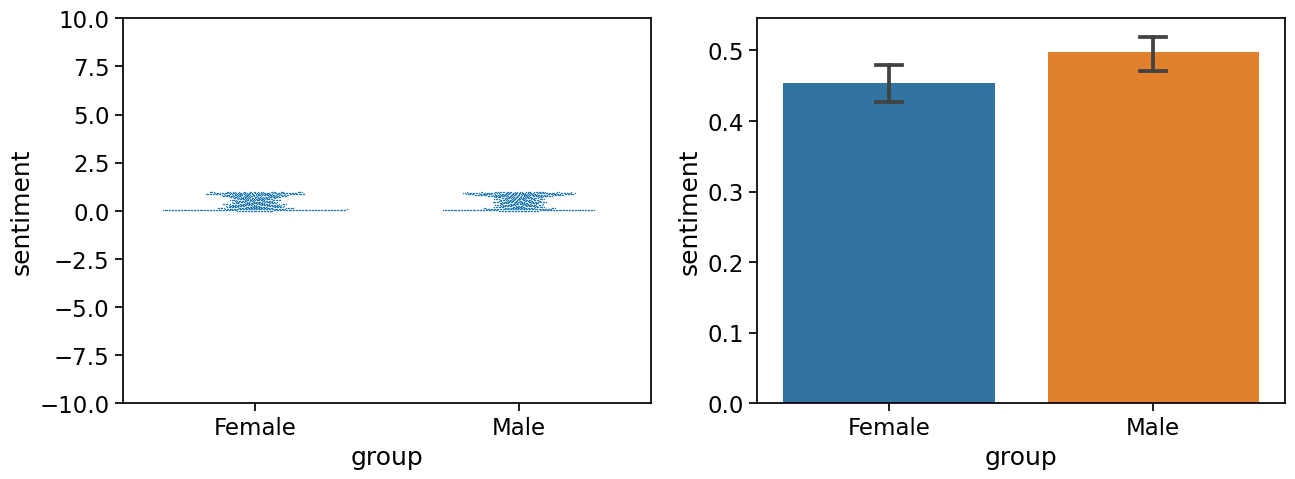

In [101]:
matplotlib.pyplot.figure(figsize=(15,5))
matplotlib.pyplot.subplot(121)
plot = seaborn.swarmplot(x='group', y='sentiment', data=result, size=1)
plot.set_ylim([-10, 10])
matplotlib.pyplot.subplot(122)
plot = seaborn.barplot(x='group', y='sentiment', data=result, capsize=.1)

In [77]:
def tokenize_data(num_top_words, max_text_length, text):
    tokenizer = Tokenizer(num_words=num_top_words)
    tokenizer.fit_on_texts(text)
    sequences = tokenizer.texts_to_sequences(text)
    word_index = tokenizer.word_index
    NUM_TOP_WORDS = len(word_index) if num_top_words==None else num_top_words
    top_words = min((len(word_index),NUM_TOP_WORDS))
    print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

    X = pad_sequences(sequences, maxlen=MAX_ART_LEN)
    return X
    

In [ ]:
# Other Biases to look into:

# religious
# gender
# ageism 
# 

# racial <- is probably the most obvious one